In [5]:
# ✅ [ResNet50 Step 1] 작업 디렉토리 확인
# 맥북용 설정
import os
print("📁 현재 작업 디렉토리:", os.getcwd())


📁 현재 작업 디렉토리: /Users/freemanyoo/develop/crawler/multi_crawler


In [ ]:
# ✅ [ResNet50 Step 2] 데이터 로딩 및 전처리 (⚖️ 클래스 불균형 해결!)
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from collections import Counter

# 데이터 폴더 경로 설정 (맥북 로컬 경로)
data_dir = "/Users/freemanyoo/develop/crawler/multi_crawler/class"

# 훈련용 데이터 증강 (Data Augmentation) - 과적합 방지!
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 표준 입력 크기
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
    transforms.RandomRotation(15),  # ±15도 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 표준
])

# 검증용 데이터 변환 (증강 없음)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 표준
])

# 전체 데이터셋 로드 (일단 검증용 transform으로)
full_dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

# 데이터셋을 훈련용(80%)과 검증용(20%)으로 분할
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 훈련 데이터셋에 증강 적용
train_dataset.dataset.transform = train_transform

# ⚖️ WeightedRandomSampler 생성 (클래스 불균형 해결!)
# 1. 훈련 데이터의 클래스별 개수 계산
train_targets = [full_dataset.targets[i] for i in train_dataset.indices]
class_counts = Counter(train_targets)
print("\n⚖️ 클래스 불균형 해결 시작...")
print("📊 훈련 데이터 클래스별 개수:")
for class_idx, count in sorted(class_counts.items()):
    print(f"  - {full_dataset.classes[class_idx]}: {count}장")

# 2. 각 클래스의 가중치 계산 (적은 클래스일수록 높은 가중치)
class_weights = {class_idx: 1.0 / count for class_idx, count in class_counts.items()}

# 3. 각 샘플에 대한 가중치 할당
sample_weights = [class_weights[target] for target in train_targets]

# 4. WeightedRandomSampler 생성
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True  # 중복 샘플링 허용 (적은 클래스를 더 자주 샘플링)
)

# 데이터 로더 생성 (sampler 사용 시 shuffle=False!)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 목록 확인
class_names = full_dataset.classes
print(f"\n✅ 클래스 목록: {class_names}")
print(f"📊 총 이미지 개수: {len(full_dataset)}장")
print(f"  🔵 훈련 데이터: {train_size}장 (80%) + 데이터 증강 적용")
print(f"  🟢 검증 데이터: {val_size}장 (20%)")
print(f"\n⚖️ WeightedRandomSampler 적용 완료!")
print(f"  → 모든 클래스를 동등하게 학습합니다! 🎯") 


✅ 클래스 목록: ['감바스', '파스타', '고추바사삭', '양념치킨', '지코바']
📊 총 이미지 개수: 1350장
  🔵 훈련 데이터: 1080장 (80%) + 데이터 증강 적용
  🟢 검증 데이터: 270장 (20%)


In [7]:
# 📌 [선택사항] 클래스별 이미지 개수 확인
import os

# 데이터 폴더 경로 설정 (맥북 로컬 경로)
data_dir = "/Users/freemanyoo/develop/crawler/multi_crawler/class"

# 폴더 안에 있는 클래스 확인
print("🔍 데이터셋 폴더 내 클래스 확인:")
if os.path.exists(data_dir):
    print(os.listdir(data_dir))
    # 각 클래스별 이미지 개수 확인
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            img_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  📁 {class_name}: {img_count}장")
else:
    print(f"❌ 경로를 찾을 수 없습니다: {data_dir}")


🔍 데이터셋 폴더 내 클래스 확인:
['파스타', '.DS_Store', '양념치킨', '지코바', '감바스', '고추바사삭']
  📁 파스타: 270장
  📁 양념치킨: 270장
  📁 지코바: 270장
  📁 감바스: 270장
  📁 고추바사삭: 270장


In [4]:
# ✅ [ResNet50 Step 3] ResNet50 모델 생성
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ResNet50 모델 사용 (전이 학습 - Transfer Learning)
# 클래스 개수 설정
num_classes = len(class_names)

# 🔥 ResNet50 사전 학습된 모델 불러오기
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# 마지막 FC Layer를 우리의 클래스 수에 맞게 변경
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# 최적화 함수 및 손실 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)  # ResNet은 더 낮은 LR

print(f"✅ ResNet50 모델 생성 완료 (클래스 수: {num_classes})")
print(f"📊 모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
print(f"🎯 전이 학습 (Transfer Learning) 적용:")
print(f"   - ImageNet 사전 학습 가중치 사용")
print(f"   - 224x224 입력 크기 (ResNet 표준)")
print(f"   - 마지막 FC Layer만 {num_classes}개 클래스로 변경")
print(f"   - Learning Rate: 0.0001")
print(f"   - Weight Decay: 0.001")
print(f"\n💪 ResNet50은 이미지 인식의 고전적 명작입니다!")
print(f"   - 25.6M 파라미터, 80.9% (ImageNet)")
print(f"   - 깊은 네트워크 (50 layers) + Residual Connection")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/freemanyoo/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 54.6MB/s]


✅ ResNet50 모델 생성 완료 (클래스 수: 5)
📊 모델 파라미터 수: 23,518,277
🎯 전이 학습 (Transfer Learning) 적용:
   - ImageNet 사전 학습 가중치 사용
   - 224x224 입력 크기 (ResNet 표준)
   - 마지막 FC Layer만 5개 클래스로 변경
   - Learning Rate: 0.0001
   - Weight Decay: 0.001

💪 ResNet50은 이미지 인식의 고전적 명작입니다!
   - 25.6M 파라미터, 80.9% (ImageNet)
   - 깊은 네트워크 (50 layers) + Residual Connection


In [8]:
# ✅ [ResNet50 Step 4] 50 에폭 학습 시작
num_epochs = 50  # 학습 횟수 (권장: 50)

# 맥북 GPU (Apple Silicon MPS) 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Apple Silicon GPU (MPS) 사용!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("🔥 CUDA GPU 사용!")
else:
    device = torch.device("cpu")
    print("💻 CPU 사용")

model.to(device)

print("🚀 ResNet50 모델 학습 시작...\n")
best_val_accuracy = 0.0  # 최고 검증 정확도 추적

for epoch in range(num_epochs):
    # ========== 훈련 단계 ==========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    # ========== 검증 단계 ==========
    model.eval()  # 평가 모드
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  🔵 훈련 - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  🟢 검증 - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    # 최고 검증 정확도 갱신 시
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f"  ✨ 새로운 최고 검증 정확도! {best_val_accuracy:.2f}%")
        # 최고 모델 즉시 저장
        torch.save(model.state_dict(), 
                   "/Users/freemanyoo/develop/crawler/multi_crawler/resnet50_best.pth")
        print(f"  💾 최고 모델 저장 완료!")
    print()

print("="*60)
print("✅ ResNet50 학습 완료!")
print(f"🏆 최종 훈련 정확도: {train_accuracy:.2f}%")
print(f"🏆 최종 검증 정확도: {val_accuracy:.2f}%")
print(f"🥇 최고 검증 정확도: {best_val_accuracy:.2f}%")
print("="*60)


🍎 Apple Silicon GPU (MPS) 사용!
🚀 ResNet50 모델 학습 시작...

Epoch [1/50]
  🔵 훈련 - Loss: 0.8227, Accuracy: 83.80%
  🟢 검증 - Loss: 0.0738, Accuracy: 98.15%
  ✨ 새로운 최고 검증 정확도! 98.15%
  💾 최고 모델 저장 완료!

Epoch [2/50]
  🔵 훈련 - Loss: 0.1193, Accuracy: 96.30%
  🟢 검증 - Loss: 0.0608, Accuracy: 97.78%

Epoch [3/50]
  🔵 훈련 - Loss: 0.0758, Accuracy: 97.41%
  🟢 검증 - Loss: 0.0303, Accuracy: 98.89%
  ✨ 새로운 최고 검증 정확도! 98.89%
  💾 최고 모델 저장 완료!



KeyboardInterrupt: 

In [9]:
# ✅ [ResNet50 Step 5] 최종 모델 저장 (선택사항)
# 맥북 로컬 경로로 모델 저장
model_path = "/Users/freemanyoo/develop/crawler/multi_crawler/resnet50.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ 학습된 ResNet50 모델이 저장되었습니다: {model_path}")


✅ 학습된 ResNet50 모델이 저장되었습니다: /Users/freemanyoo/develop/crawler/multi_crawler/resnet50.pth


In [10]:
# ⛔⛔⛔ [1차 학습 후 실행!] ⛔⛔⛔
# 🔥 [ResNet50 Fine-tuning] 더 강한 데이터 증강
print("🔄 추가 학습을 위해 데이터 증강을 강화합니다...")

train_transform_enhanced = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),  # 15 → 20도로 증가
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # 더 강화
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 약간의 이동
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 표준
])

# 훈련 데이터셋에 강화된 증강 적용
train_dataset.dataset.transform = train_transform_enhanced

# 데이터 로더 재생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("✅ 데이터 증강 강화 완료!")
print("   - 이미지 크기: 224x224 (ResNet 표준)")
print("   - 회전: ±20도")
print("   - 색상 변화: 30%")
print("   - 위치 이동: 10%")


🔄 추가 학습을 위해 데이터 증강을 강화합니다...
✅ 데이터 증강 강화 완료!
   - 이미지 크기: 224x224 (ResNet 표준)
   - 회전: ±20도
   - 색상 변화: 30%
   - 위치 이동: 10%


In [11]:
# ⛔⛔⛔ [1차 학습 후 실행!] ⛔⛔⛔
# 🎯 [ResNet50 Fine-tuning] 30 에폭 추가 학습
print("🚀 ResNet50 추가 학습을 시작합니다...\n")

# Learning Rate를 더 낮춰서 미세 조정
optimizer = optim.Adam(model.parameters(), lr=0.00003, weight_decay=0.001)
# 기존 0.0001 → 0.00003 (더 낮게)

num_epochs = 30  # 30 에폭 추가 학습

# 맥북 GPU (Apple Silicon MPS) 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Apple Silicon GPU (MPS) 사용!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("🔥 CUDA GPU 사용!")
else:
    device = torch.device("cpu")
    print("💻 CPU 사용")

model.to(device)

print(f"📊 ResNet50 Fine-tuning 시작")
print(f"🎯 목표: 1차 학습 결과를 넘어서기\n")

best_val_accuracy = 0.0  # Fine-tuning 최고 기록

for epoch in range(num_epochs):
    # ========== 훈련 단계 ==========
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    # ========== 검증 단계 ==========
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    # 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  🔵 훈련 - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
    print(f"  🟢 검증 - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
    
    # 최고 검증 정확도 갱신 시
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print(f"  ✨ 새로운 최고 검증 정확도! {best_val_accuracy:.2f}%")
        # Fine-tuned 모델 저장 (별도 파일명)
        torch.save(model.state_dict(), 
                   "/Users/freemanyoo/develop/crawler/multi_crawler/resnet50_finetuned_best.pth")
        print(f"  💾 Fine-tuned 모델 저장 완료! (resnet50_finetuned_best.pth)")
    print()

print("="*60)
print("✅ ResNet50 추가 학습 완료!")
print(f"🏆 최종 훈련 정확도: {train_accuracy:.2f}%")
print(f"🏆 최종 검증 정확도: {val_accuracy:.2f}%")
print(f"🥇 최고 검증 정확도: {best_val_accuracy:.2f}%")
print("="*60)


🚀 ResNet50 추가 학습을 시작합니다...

🍎 Apple Silicon GPU (MPS) 사용!
📊 ResNet50 Fine-tuning 시작
🎯 목표: 1차 학습 결과를 넘어서기

Epoch [1/30]
  🔵 훈련 - Loss: 0.1321, Accuracy: 96.11%
  🟢 검증 - Loss: 0.0516, Accuracy: 98.52%
  ✨ 새로운 최고 검증 정확도! 98.52%
  💾 Fine-tuned 모델 저장 완료! (resnet50_finetuned_best.pth)

Epoch [2/30]
  🔵 훈련 - Loss: 0.0744, Accuracy: 97.41%
  🟢 검증 - Loss: 0.0389, Accuracy: 98.89%
  ✨ 새로운 최고 검증 정확도! 98.89%
  💾 Fine-tuned 모델 저장 완료! (resnet50_finetuned_best.pth)



KeyboardInterrupt: 

In [ ]:
# 🔄 [예측 Step 1] 최고 성능 ResNet50 모델 불러오기
# 필요한 import 및 변수 설정
import torch
import torch.nn as nn
from torchvision import models

# 맥북 GPU (Apple Silicon MPS) 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 클래스 개수 설정
# 클래스 개수 설정 (⚠️ 학습 시 사용한 클래스 순서와 동일해야 함!)
# ImageFolder는 알파벳 순서로 자동 정렬됨
class_names = ['감바스', '숯불치킨', '양념치킨', '파스타', '후라이드치킨']
num_classes = len(class_names)

# ResNet50 모델 불러오기 함수
def load_resnet50_model(model_path, num_classes, device):
    # ResNet50 구조 생성
    model = models.resnet50(weights=None)  # 가중치 없이 구조만 생성
    
    # 마지막 FC Layer를 클래스 수에 맞게 변경
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    # 저장된 가중치 불러오기
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# 🏆 최고 성능 ResNet50 모델 불러오기
best_model_path = "/Users/freemanyoo/develop/crawler/multi_crawler/resnet50_finetuned_best.pth"
loaded_model = load_resnet50_model(best_model_path, num_classes, device)
print(f"✅ ResNet50 모델 불러오기 완료! (Device: {device})")
print(f"📊 전이 학습으로 훈련된 ResNet50 모델")
print(f"💾 모델 경로: {best_model_path}")


✅ ResNet50 모델 불러오기 완료! (Device: mps)
📊 전이 학습으로 훈련된 ResNet50 모델
💾 모델 경로: /Users/freemanyoo/develop/crawler/multi_crawler/resnet50_finetuned_best.pth


✅ 16개의 샘플 이미지를 발견했습니다!
💪 ResNet50 모델로 예측

📸 [1/16] sample1.png


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


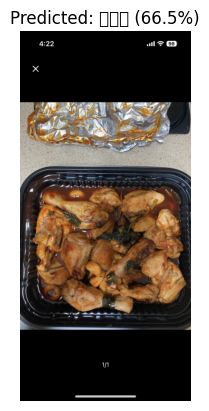

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 66.49%
🥈 2위: 파스타          - 19.14%
🥉 3위: 지코바          -  9.15%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [2/16] sample2.png


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


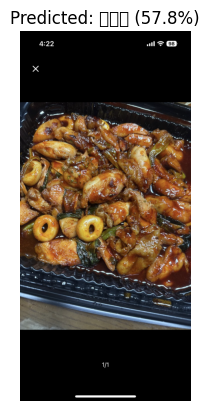

/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 지코바          - 57.78%
🥈 2위: 파스타          - 16.79%
🥉 3위: 감바스          - 11.36%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [3/16] sample3.png


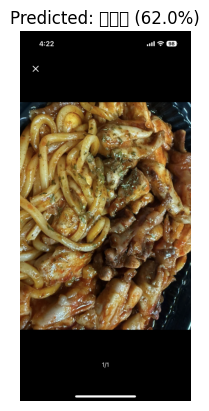

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 파스타          - 61.99%
🥈 2위: 지코바          - 22.13%
🥉 3위: 양념치킨         -  8.24%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [4/16] sample4.png


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45392 (\N{HANGUL SYLLABLE NYEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53416 (\N{HANGUL SYLLABLE KIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


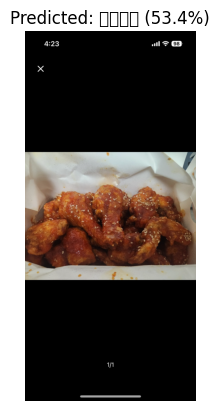

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 53.36%
🥈 2위: 파스타          - 27.51%
🥉 3위: 고추바사삭        -  7.63%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [5/16] sample5.png


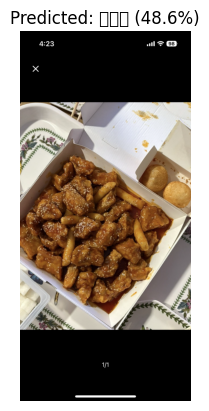

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 48.58%
🥈 2위: 지코바          - 21.34%
🥉 3위: 양념치킨         - 17.18%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [6/16] sample6.png


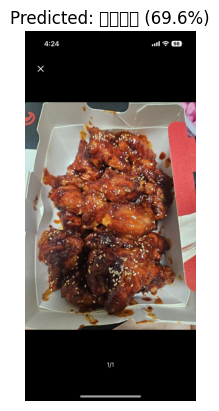

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 69.57%
🥈 2위: 지코바          - 24.49%
🥉 3위: 파스타          -  3.70%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [7/16] sample7.png


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49325 (\N{HANGUL SYLLABLE SAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


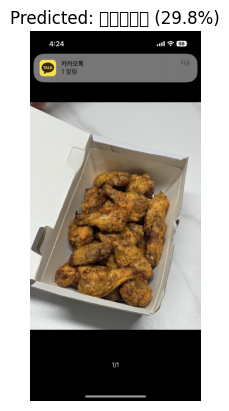

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 고추바사삭        - 29.83%
🥈 2위: 양념치킨         - 28.64%
🥉 3위: 파스타          - 20.52%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [8/16] sample8.png


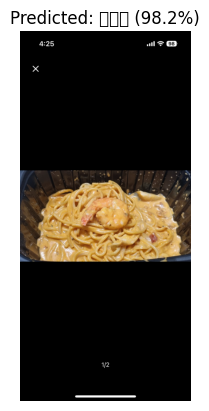

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 파스타          - 98.22%
🥈 2위: 감바스          -  0.54%
🥉 3위: 양념치킨         -  0.47%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [9/16] sample9.png


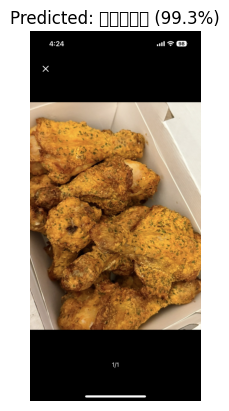

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 고추바사삭        - 99.33%
🥈 2위: 양념치킨         -  0.28%
🥉 3위: 감바스          -  0.15%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [10/16] sample10.png


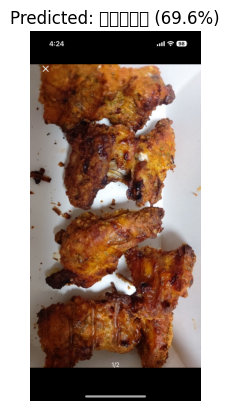

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 고추바사삭        - 69.55%
🥈 2위: 양념치킨         - 13.63%
🥉 3위: 감바스          -  7.53%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [11/16] sample11.png


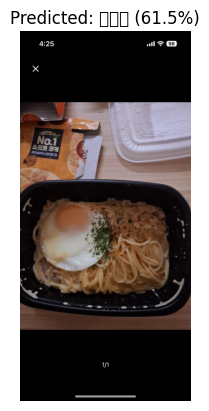

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 파스타          - 61.49%
🥈 2위: 감바스          - 35.90%
🥉 3위: 고추바사삭        -  0.92%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [12/16] sample12.png


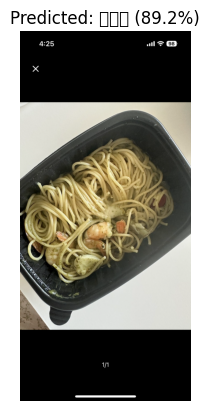

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 파스타          - 89.20%
🥈 2위: 감바스          -  4.22%
🥉 3위: 지코바          -  2.39%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [13/16] sample13.png


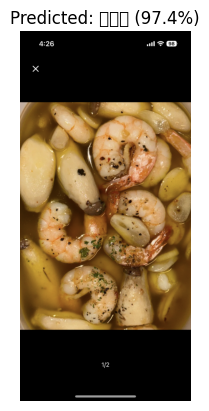

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 97.42%
🥈 2위: 파스타          -  1.78%
🥉 3위: 양념치킨         -  0.30%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [14/16] sample14.png


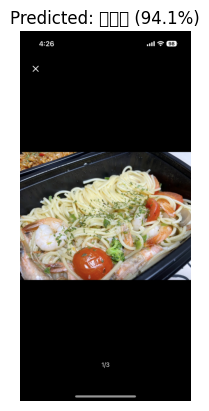

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 파스타          - 94.14%
🥈 2위: 감바스          -  4.34%
🥉 3위: 양념치킨         -  0.62%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [15/16] sample15.png


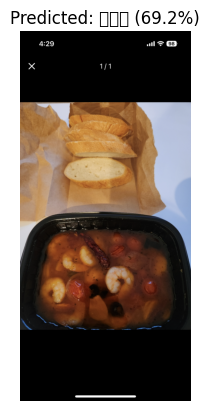

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 69.25%
🥈 2위: 파스타          - 14.67%
🥉 3위: 지코바          -  7.18%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [16/16] sample16.png


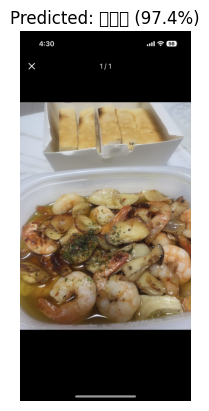

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 97.36%
🥈 2위: 파스타          -  2.15%
🥉 3위: 지코바          -  0.21%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



In [13]:
# 🔄 [예측 Step 2] 샘플 이미지 예측
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def predict_sample(image_path, model, device):
    """
    저장된 ResNet50 모델을 사용하여 샘플 이미지를 예측하는 함수.
    """
    # 이미지 불러오기 및 전처리
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet 표준
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # 모델 예측
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        
        # 상위 3개 클래스와 확률
        top3_probs, top3_indices = torch.topk(probabilities, min(3, len(class_names)))
        predicted = top3_indices[0]

    # 결과 출력
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {class_names[predicted.item()]} ({top3_probs[0]*100:.1f}%)")
    plt.axis('off')
    plt.show()

    print(f"🎯 예측 결과 (ResNet50):")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    for i in range(len(top3_indices)):
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
        print(f"{emoji} {i+1}위: {class_names[top3_indices[i]]:12s} - {top3_probs[i]*100:5.2f}%")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

# 🏆 여러 샘플 이미지 순서대로 예측 실행
import os
base_dir = "/Users/freemanyoo/develop/crawler/multi_crawler"
sample_prefix = "sample"
sample_ext = ".png"

# sample1.png, sample2.png, ... 순서대로 검증
found_samples = []
for i in range(1, 100):
    sample_path = f"{base_dir}/{sample_prefix}{i}{sample_ext}"
    if os.path.exists(sample_path):
        found_samples.append(sample_path)
    elif i > 1 and len(found_samples) > 0:
        break

if found_samples:
    print(f"✅ {len(found_samples)}개의 샘플 이미지를 발견했습니다!")
    print(f"💪 ResNet50 모델로 예측\n")
    for idx, sample_path in enumerate(found_samples, 1):
        print(f"{'='*60}")
        print(f"📸 [{idx}/{len(found_samples)}] {os.path.basename(sample_path)}")
        print(f"{'='*60}")
        predict_sample(sample_path, loaded_model, device)
        print()
else:
    print(f"⚠️  샘플 이미지를 찾을 수 없습니다!")
    print(f"💡 {base_dir}/sample1.png 형식으로 이미지를 준비해주세요!")


🔧 샘플 이미지 배경 제거 + 전처리 후 재예측 (ResNet50)

🤖 BiRefNet 모델 로딩 중...
⚠️  메모리 부족 시 커널이 크래시할 수 있습니다...


/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/opt/anaconda3/envs/birefnet/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


✅ BiRefNet 모델 로딩 완료!

✅ 16개의 샘플 이미지를 발견했습니다!
🔧 전처리(배경 제거 + 224x224 리사이즈 + 패딩) 적용 중...

📸 [1/16] sample1.png


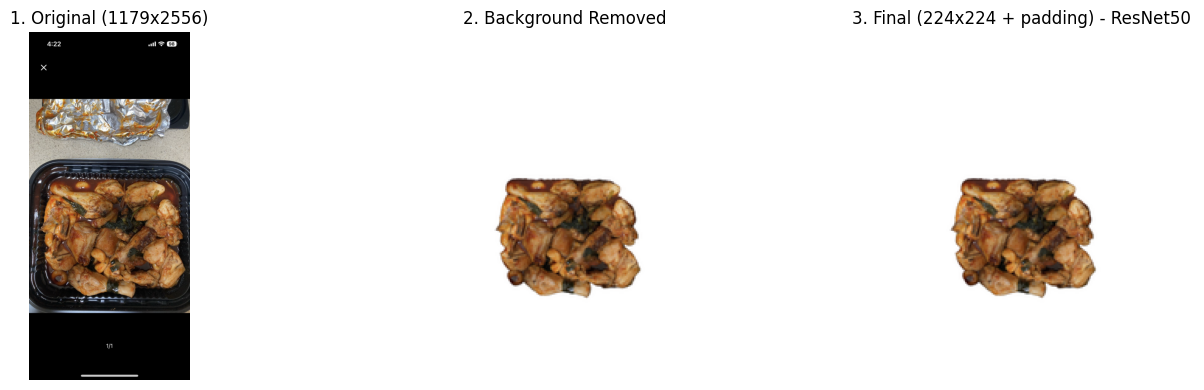

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 82.08%
🥈 2위: 파스타          -  5.66%
🥉 3위: 양념치킨         -  5.32%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [2/16] sample2.png


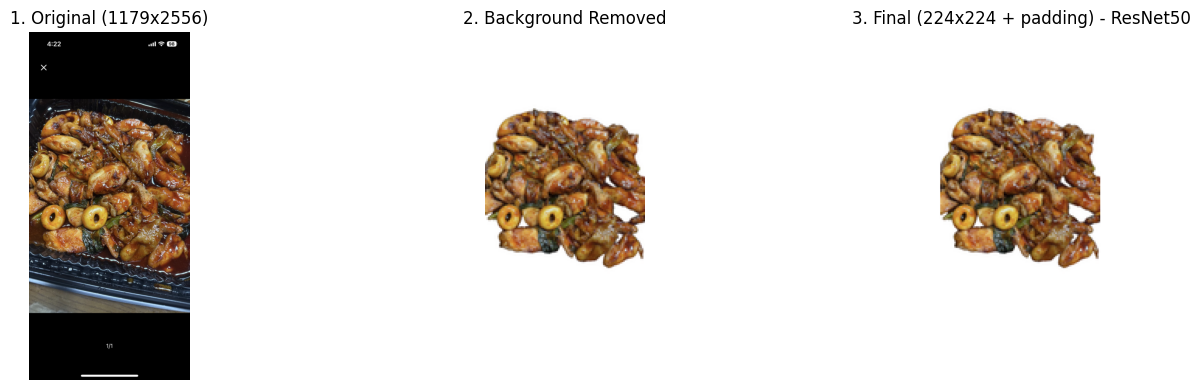

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 42.73%
🥈 2위: 지코바          - 34.66%
🥉 3위: 감바스          - 16.68%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [3/16] sample3.png


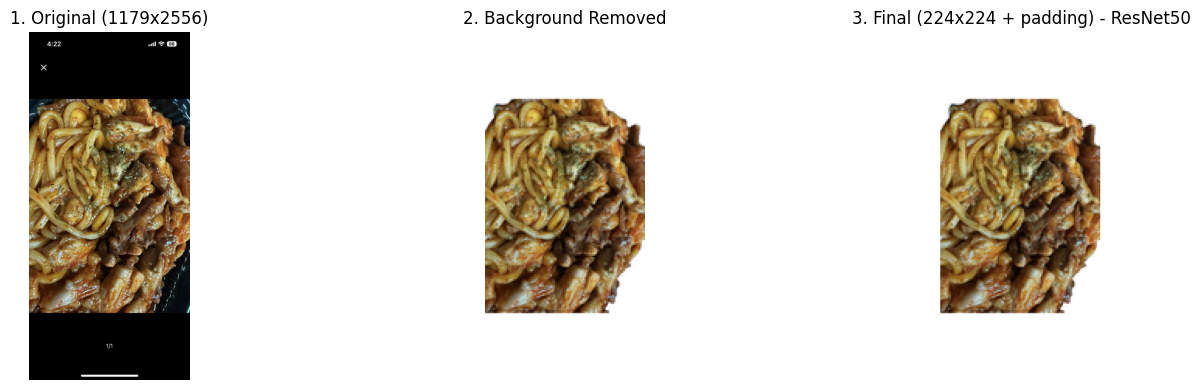

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 45.30%
🥈 2위: 지코바          - 31.90%
🥉 3위: 파스타          - 12.00%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [4/16] sample4.png


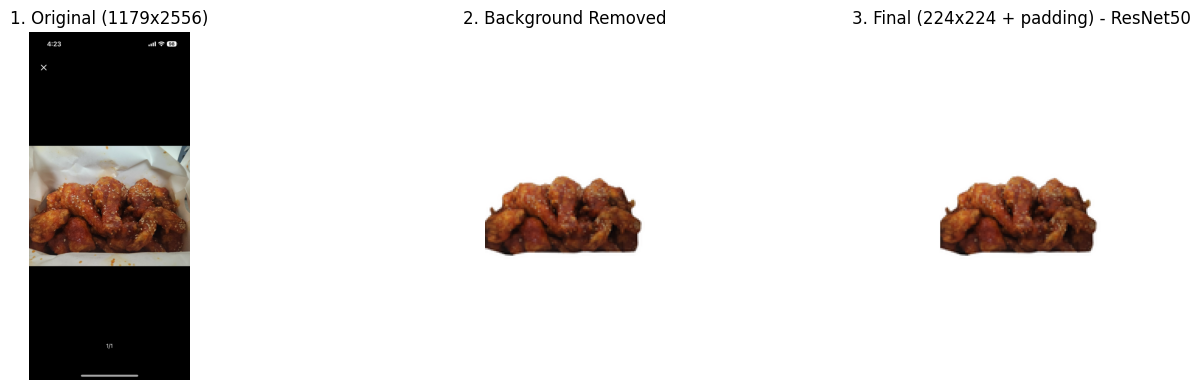

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 67.88%
🥈 2위: 고추바사삭        - 17.06%
🥉 3위: 감바스          -  6.31%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [5/16] sample5.png


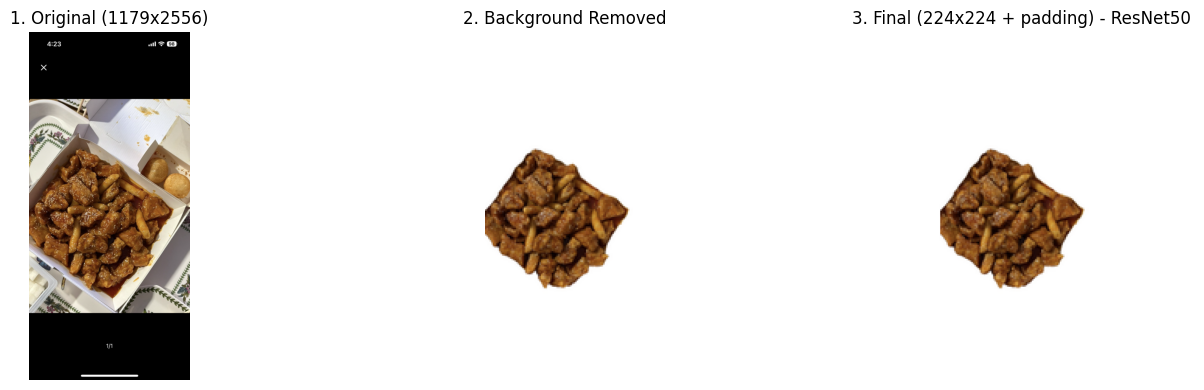

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 52.95%
🥈 2위: 감바스          - 16.16%
🥉 3위: 고추바사삭        - 10.96%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [6/16] sample6.png


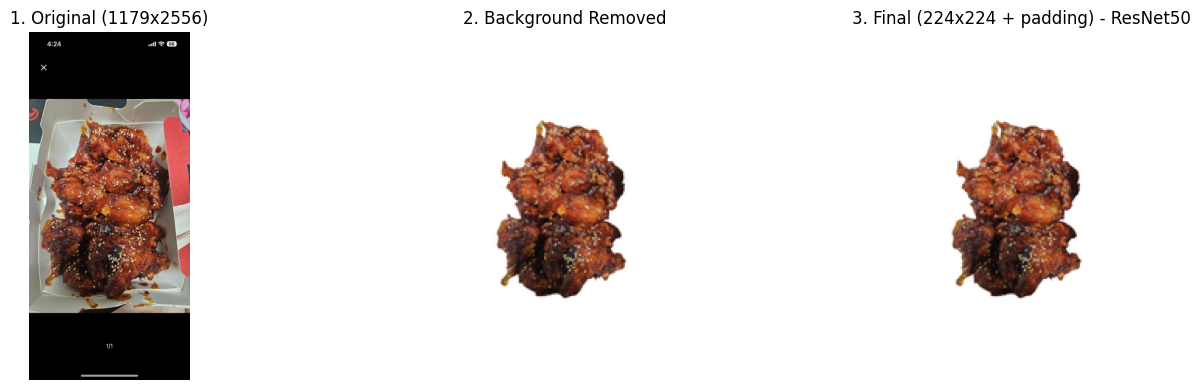

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 97.34%
🥈 2위: 지코바          -  0.91%
🥉 3위: 고추바사삭        -  0.83%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [7/16] sample7.png


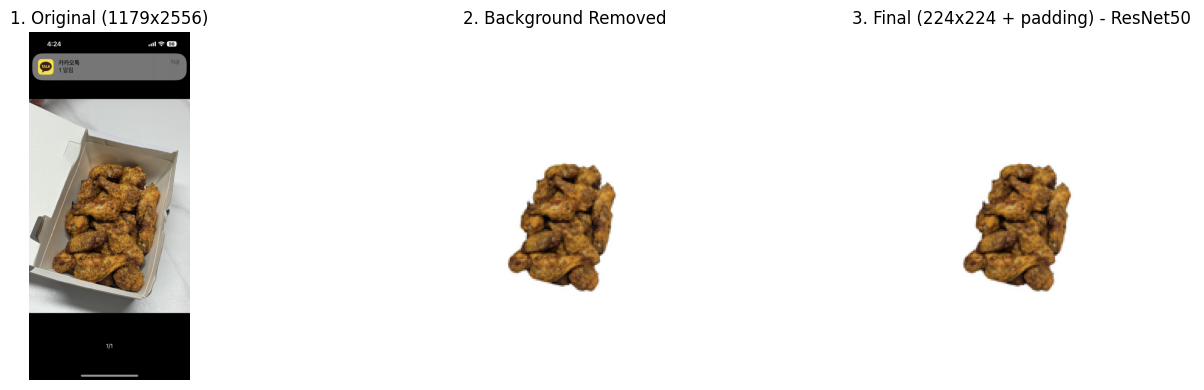

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 양념치킨         - 45.63%
🥈 2위: 고추바사삭        - 39.26%
🥉 3위: 감바스          -  7.16%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [8/16] sample8.png


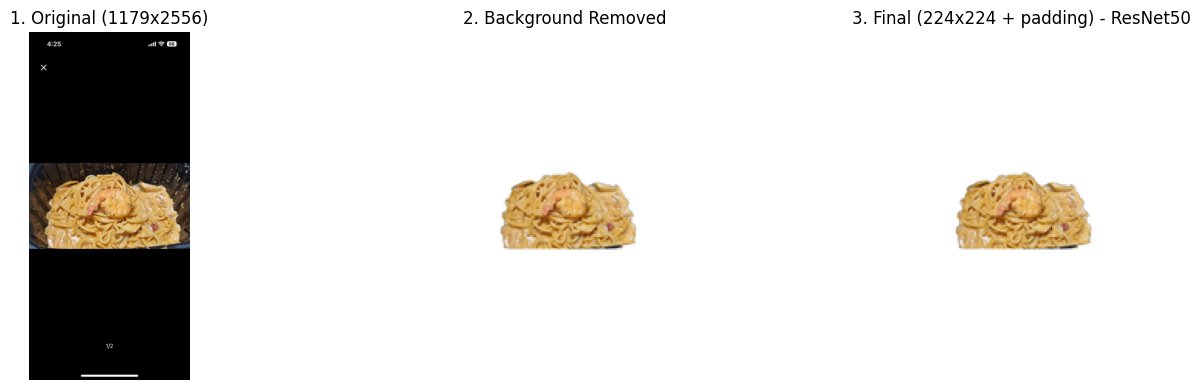

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 파스타          - 45.14%
🥈 2위: 감바스          - 30.23%
🥉 3위: 양념치킨         - 12.44%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [9/16] sample9.png


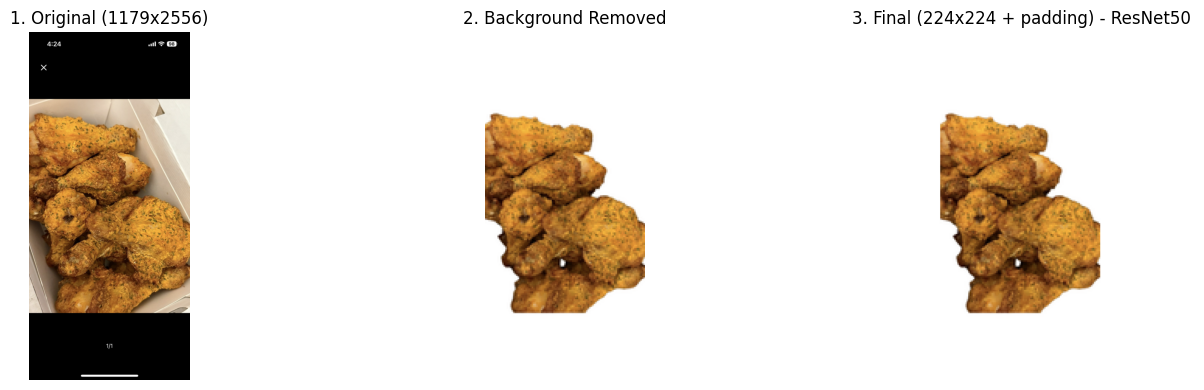

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 고추바사삭        - 86.50%
🥈 2위: 양념치킨         - 10.26%
🥉 3위: 감바스          -  1.46%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [10/16] sample10.png


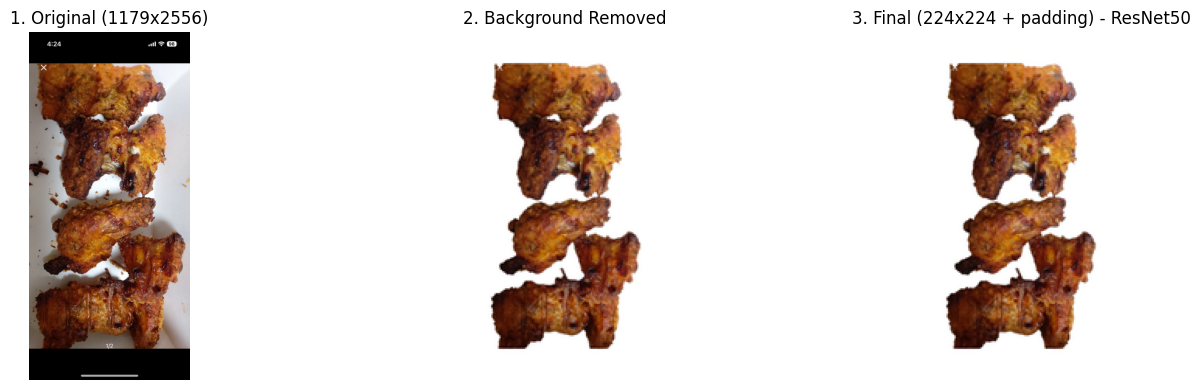

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 고추바사삭        - 92.27%
🥈 2위: 양념치킨         -  5.88%
🥉 3위: 지코바          -  0.77%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [11/16] sample11.png


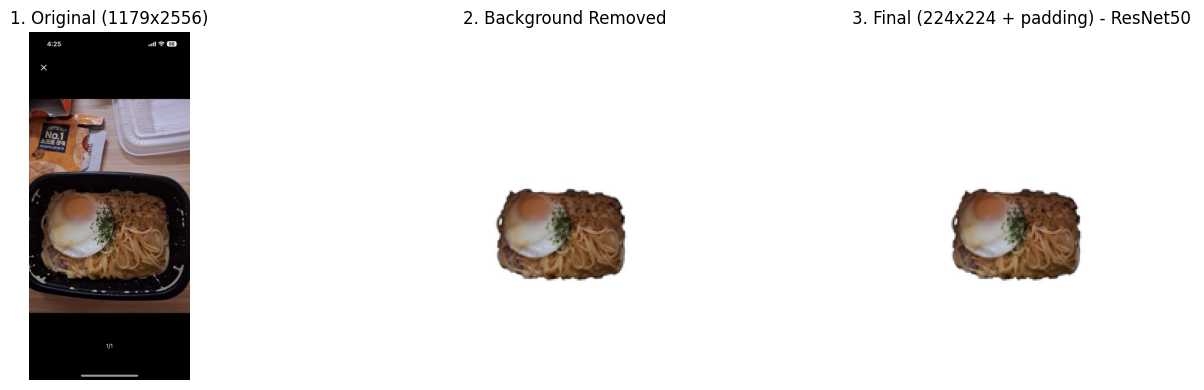

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 59.65%
🥈 2위: 파스타          - 14.82%
🥉 3위: 양념치킨         - 13.71%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [12/16] sample12.png


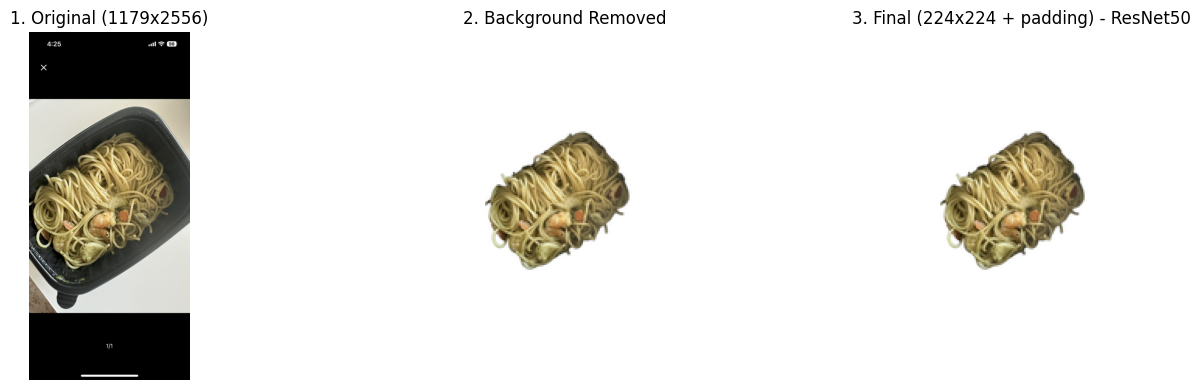

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 파스타          - 76.19%
🥈 2위: 감바스          -  9.60%
🥉 3위: 양념치킨         -  6.68%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [13/16] sample13.png


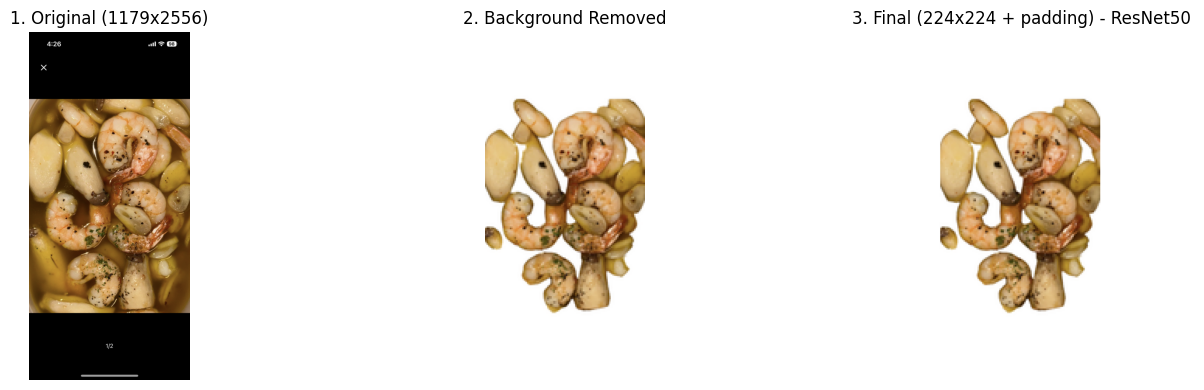

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 99.76%
🥈 2위: 파스타          -  0.11%
🥉 3위: 양념치킨         -  0.06%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [14/16] sample14.png


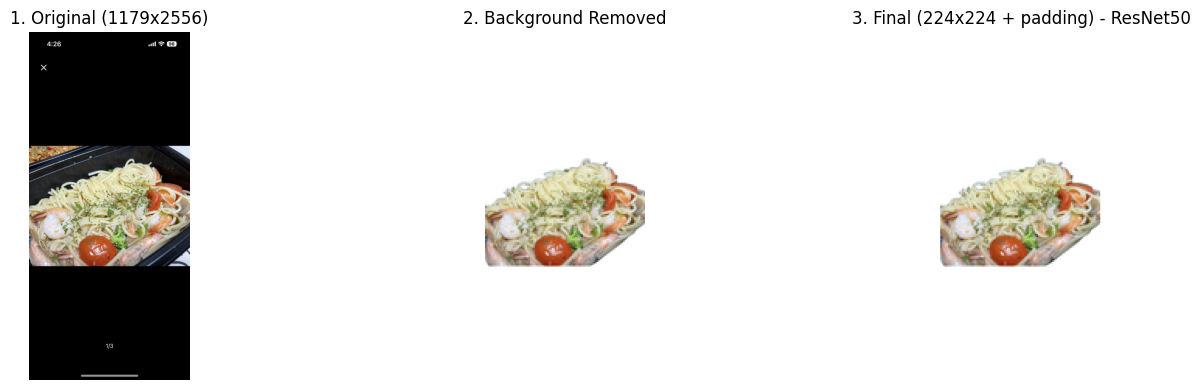

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 76.25%
🥈 2위: 파스타          - 13.50%
🥉 3위: 양념치킨         -  4.48%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [15/16] sample15.png


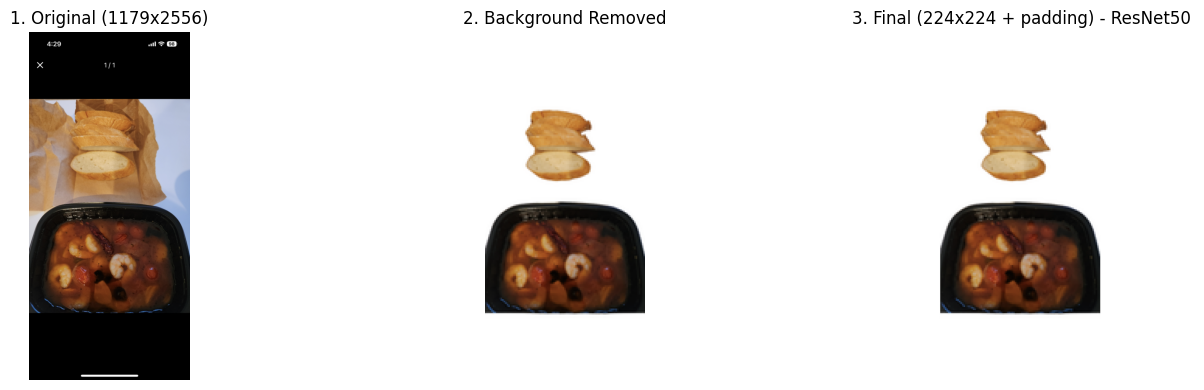

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 68.14%
🥈 2위: 양념치킨         - 10.19%
🥉 3위: 지코바          -  8.70%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📸 [16/16] sample16.png


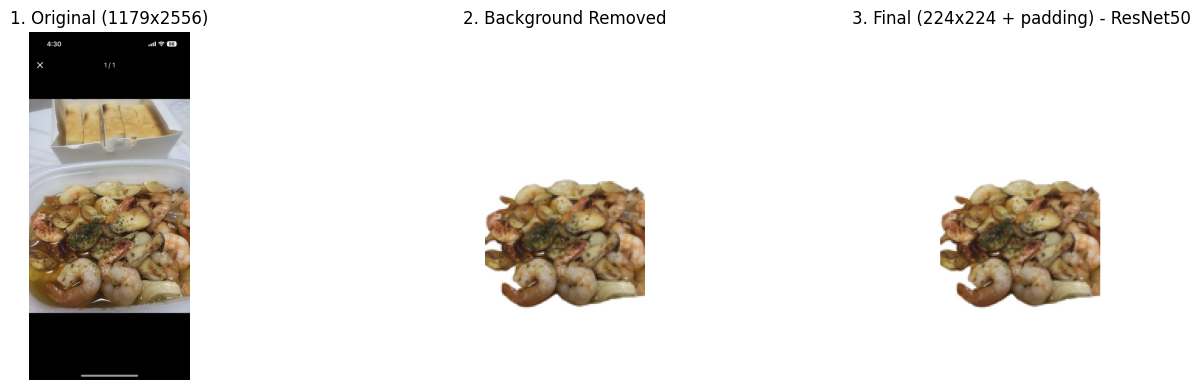

🎯 예측 결과 (ResNet50):
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🥇 1위: 감바스          - 99.63%
🥈 2위: 파스타          -  0.15%
🥉 3위: 지코바          -  0.11%
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 전처리 후 예측 결과 요약 (ResNet50)
sample1.png     → 감바스          (82.08%)
sample2.png     → 양념치킨         (42.73%)
sample3.png     → 양념치킨         (45.30%)
sample4.png     → 양념치킨         (67.88%)
sample5.png     → 양념치킨         (52.95%)
sample6.png     → 양념치킨         (97.34%)
sample7.png     → 양념치킨         (45.63%)
sample8.png     → 파스타          (45.14%)
sample9.png     → 고추바사삭        (86.50%)
sample10.png    → 고추바사삭        (92.27%)
sample11.png    → 감바스          (59.65%)
sample12.png    → 파스타          (76.19%)
sample13.png    → 감바스          (99.76%)
sample14.png    → 감바스          (76.25%)
sample15.png    → 감바스          (68.14%)
sample16.png    → 감바스          (99.63%)


In [14]:
# 🔄 [예측 Step 3] 배경 제거 + 전처리 후 재예측 (선택사항)
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

print("="*60)
print("🔧 샘플 이미지 배경 제거 + 전처리 후 재예측 (ResNet50)")
print("="*60)
print()

# BiRefNet 모델 로드
print("🤖 BiRefNet 모델 로딩 중...")
print("⚠️  메모리 부족 시 커널이 크래시할 수 있습니다...")
import numpy as np
from transformers import AutoModelForImageSegmentation
import gc

# 메모리 정리
gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

try:
    # CNN 모델을 CPU로 이동시켜 GPU 메모리 확보
    loaded_model.to('cpu')
    torch.mps.empty_cache()
    
    with torch.no_grad():
        birefnet = AutoModelForImageSegmentation.from_pretrained(
            'ZhengPeng7/BiRefNet',
            trust_remote_code=True,
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )
        birefnet.to(device)
        birefnet.eval()
        torch.mps.empty_cache()
    
    # CNN 모델 다시 GPU로
    loaded_model.to(device)
    
    print("✅ BiRefNet 모델 로딩 완료!")
except Exception as e:
    print(f"❌ BiRefNet 로딩 실패: {e}")
    print("⚠️  배경 제거 없이 진행합니다.")
    birefnet = None
    loaded_model.to(device)

print()

def remove_background(image, birefnet_model, device):
    """BiRefNet을 사용하여 배경 제거"""
    if birefnet_model is None:
        return image
    
    from torchvision import transforms as T
    
    input_size = (1024, 1024)
    transform = T.Compose([
        T.Resize(input_size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(image).unsqueeze(0).to(device).half()
    
    with torch.no_grad():
        preds = birefnet_model(input_tensor)[-1].sigmoid().cpu()
    
    pred = preds[0].squeeze()
    pred_pil = T.ToPILImage()(pred)
    mask = pred_pil.resize(image.size)
    
    image_rgba = image.convert("RGBA")
    image_rgba.putalpha(mask)
    
    white_bg = Image.new("RGB", image.size, (255, 255, 255))
    white_bg.paste(image_rgba, (0, 0), image_rgba)
    
    return white_bg

def preprocess_and_predict(image_path, model, birefnet_model, device):
    """샘플 이미지를 배경 제거 + 전처리 후 예측"""
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    
    # 1. 배경 제거
    image_nobg = remove_background(image, birefnet_model, device)
    
    # 2. 224x224로 리사이즈 + 패딩 (ResNet 표준)
    target_size = (224, 224)
    image_nobg.thumbnail(target_size, Image.Resampling.LANCZOS)
    
    new_image = Image.new("RGB", target_size, (255, 255, 255))
    paste_position = ((target_size[0] - image_nobg.size[0]) // 2,
                      (target_size[1] - image_nobg.size[1]) // 2)
    new_image.paste(image_nobg, paste_position)
    
    # 모델 입력용 전처리 (ResNet은 ImageNet 표준 정규화)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(new_image).unsqueeze(0).to(device)
    
    # 예측
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        top3_probs, top3_indices = torch.topk(probabilities, min(3, len(class_names)))
        predicted = top3_indices[0]
    
    # 결과 출력
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(Image.open(image_path))
    plt.title(f"1. Original ({original_size[0]}x{original_size[1]})")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(image_nobg)
    plt.title(f"2. Background Removed")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(new_image)
    plt.title(f"3. Final (224x224 + padding) - ResNet50")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"🎯 예측 결과 (ResNet50):")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    for i in range(len(top3_indices)):
        emoji = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
        print(f"{emoji} {i+1}위: {class_names[top3_indices[i]]:12s} - {top3_probs[i]*100:5.2f}%")
    print(f"━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    return predicted.item(), top3_probs[0].item()

# 샘플 이미지 전처리 후 예측 실행
base_dir = "/Users/freemanyoo/develop/crawler/multi_crawler"
sample_prefix = "sample"
sample_ext = ".png"

found_samples = []
for i in range(1, 100):
    sample_path = f"{base_dir}/{sample_prefix}{i}{sample_ext}"
    if os.path.exists(sample_path):
        found_samples.append(sample_path)
    elif i > 1 and len(found_samples) > 0:
        break

if found_samples:
    print(f"✅ {len(found_samples)}개의 샘플 이미지를 발견했습니다!")
    print(f"🔧 전처리(배경 제거 + 224x224 리사이즈 + 패딩) 적용 중...\n")
    
    results = []
    for idx, sample_path in enumerate(found_samples, 1):
        print(f"{'='*60}")
        print(f"📸 [{idx}/{len(found_samples)}] {os.path.basename(sample_path)}")
        print(f"{'='*60}")
        predicted_class, confidence = preprocess_and_predict(sample_path, loaded_model, birefnet, device)
        results.append((os.path.basename(sample_path), class_names[predicted_class], confidence))
        print()
    
    # 최종 요약
    print("="*60)
    print("📊 전처리 후 예측 결과 요약 (ResNet50)")
    print("="*60)
    for filename, pred_class, conf in results:
        print(f"{filename:15s} → {pred_class:12s} ({conf*100:5.2f}%)")
    print("="*60)
else:
    print(f"⚠️  샘플 이미지를 찾을 수 없습니다!")
    print(f"💡 {base_dir}/sample1.png 형식으로 이미지를 준비해주세요!")
